# Building a curated database of published bisulfite sequencing data
**start date**: 1 Dec 2015

In [65]:
from __future__ import print_function
from io import StringIO
import requests
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
runs = pd.read_table('../data/runs_ena.txt', header=0)

In [59]:
runs.describe()

study_accession sample_accession secondary_sample_accession  \
count             3636             3636                       3636   
unique             135             2552                       2552   
top        PRJNA257556     SAMN03765231                  SRS956675   
freq               934               96                         96   

       experiment_accession run_accession     instrument_model  \
count                  3636          3636                 3636   
unique                 2766          3636                    8   
top              SRX1053787     SRR771692  Illumina HiSeq 2000   
freq                     96             1                 1805   

       library_strategy library_layout  \
count              3636           3636   
unique                2              2   
top       Bisulfite-Seq         SINGLE   
freq               2252           2221   

                                                fastq_ftp  \
count                                                3572   
unique                                               3572   
top     ftp.sra.ebi.ac.uk/vol1/fastq/SRR179/003/SRR179...   
freq                                                    1   

                                            submitted_ftp  
count                                                 259  
unique                                                259  
top     ftp.sra.ebi.ac.uk/vol1/ERA051/ERA051872/fastq/...  
freq                                                    1

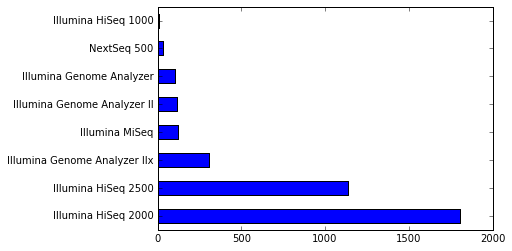

In [68]:
runs.instrument_model.value_counts().plot(kind='barh')

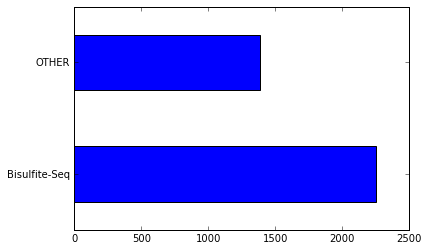

In [69]:
runs.library_strategy.value_counts().plot(kind='barh')

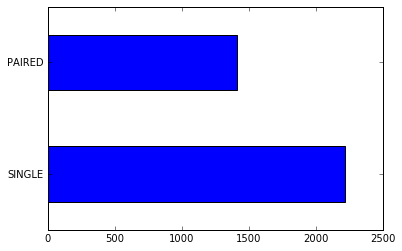

In [70]:
runs.library_layout.value_counts().plot(kind='barh')

In [62]:
missing_fastqfile = runs.fastq_ftp.isnull() & runs.submitted_ftp.isnull()
print(runs[missing_fastqfile][["run_accession","study_accession"]].to_string(index=False))

run_accession study_accession
  SRR1761091     PRJNA270616
  SRR2183100     PRJNA270874
  SRR2183101     PRJNA270874
  SRR2183102     PRJNA270874
  SRR2183103     PRJNA270874
  SRR2183104     PRJNA270874
  SRR2183105     PRJNA270874
  SRR2183106     PRJNA270874
  SRR2183107     PRJNA270874
  SRR2183108     PRJNA270874
  SRR2922654     PRJNA302602
  SRR2922655     PRJNA302602
  SRR2922656     PRJNA302602
  SRR2922657     PRJNA302602
  SRR2922658     PRJNA302602
  SRR3064997     PRJNA307202
  SRR3064998     PRJNA307202
  SRR3068020     PRJNA307202
  SRR3091435     PRJNA308231
  SRR3091436     PRJNA308231
  SRR3384734     PRJNA318516
  SRR3384735     PRJNA318516
  SRR3384736     PRJNA318516
  SRR3384737     PRJNA318516
  SRR3384738     PRJNA318516
  SRR3384739     PRJNA318516
  SRR3384740     PRJNA318516
  SRR3384741     PRJNA318516
  SRR3657353     PRJNA324637
  SRR3657354     PRJNA324637


## Merge metadata

In [260]:
sam = pd.read_table("../data/samples_ena2.txt", header=0)
exp = pd.read_table("../data/experiments_ena2.txt", header=0)

In [261]:
meta = (runs.merge(sam, left_on="secondary_sample_accession", right_on="accession")
        .merge(exp, left_on="experiment_accession", right_on="accession"))

In [262]:
meta_cat = meta[categorical_variables(meta)]

In [264]:
meta_cat = meta_cat.assign(gt_info = meta[newcol['genotype']].any(axis=1)) # assume col0 if nothing given here

In [267]:
meta_cat = meta_cat.assign(col = meta_cat.apply(lambda x: x.str.lower().str.contains('col'), axis=1).any(axis=1))

In [268]:
pattern = '.fite|\ bs|\ methyl|^bs|^methyl'
meta_cat = meta_cat.assign(bs = meta_cat.apply(lambda x: x.str.lower().str.contains(pattern), axis=1).any(axis=1))

In [282]:
def take(data):
    val = False
    if data.bs and data.col:
        val = True
    elif data.bs and not data.gt_info:
        val = True
    return val

meta_colbs = meta_cat[meta_cat[['gt_info', 'col', 'bs']].apply(lambda x: take(x), axis=1)]

In [283]:
len(meta_colbs)

1376

## Curation of metadata

1. We write the meta data to a csv file for manual curation of the data in a spreadsheet application.
2. MANUAL: delete columns that we do not need because the information is sparse/useless or redundant.
3. MANUAL: identify columns that can be merged into a single column.

**1. Load metadata.**

In [1]:
import pandas as pd

meta = pd.read_table('../data/meta_ENA_2016-08-17_uncurated.txt')

** 2. Screen levels of each categorical (i.e. non-numeric) variable to decide which columns to use and to detect columns that can be joined.**

In [112]:
# some helper functions
def categorical_variables(dframe):
    variables = list(set(dframe.columns) - set(dframe._get_numeric_data().columns))
    variables.sort(key=str.lower)
    return variables

def levels(dframe, variables):
    for var in variables:
        yield dframe[var].value_counts()

In [3]:
lev = levels(meta, categorical_variables(meta))

In [4]:
next(lev)

SRS827800     1
SRS1146921    1
SRS394683     1
SRS541201     1
SRS400824     1
SRS1166783    1
SRS348309     1
SRS1146399    1
SRS353457     1
SRS813710     1
SRS1146556    1
SRS1146586    1
SRS1146808    1
SRS1146746    1
SRS1146978    1
SRS1146384    1
SRS1146976    1
SRS1147233    1
SRS1146744    1
SRS353488     1
SRS1146478    1
SRS827182     1
SRS1147207    1
SRS466003     1
SRS541152     1
SRS353439     1
SRS1146798    1
SRS1147078    1
SRS882288     1
SRS1028980    1
             ..
SRS1111574    1
DRS019632     1
SRS1147251    1
SRS541105     1
SRS1146960    1
SRS295637     1
SRS827804     1
SRS541266     1
SRS1146827    1
SRS400834     1
SRS473163     1
SRS003093     1
SRS1146494    1
SRS511014     1
SRS1146881    1
SRS1146620    1
SRS719227     1
SRS349539     1
SRS353480     1
SRS1146991    1
SRS1147157    1
SRS507072     1
DRS030794     1
SRS353498     1
SRS1147117    1
SRS827792     1
SRS507073     1
SRS1146415    1
SRS1146335    1
SRS1147006    1
Name: accession, dtype: 

In [5]:
useful_columns = list()
useful_columns.append('accession')
useful_columns.append('accession name')
useful_columns.append('age')
useful_columns.append('alias')
useful_columns.append('background')
useful_columns.append('background ecotype')
useful_columns.append('cell type')
useful_columns.append('cell_type')
useful_columns.append('cultivar')
useful_columns.append('description')
useful_columns.append('dev_stage')
useful_columns.append('development stage')
useful_columns.append('developmental stage')
useful_columns.append('dna source')
useful_columns.append('ecotype')
useful_columns.append('ecotype background')
useful_columns.append('genetic background')
useful_columns.append('genetic backround')
useful_columns.append('genotype')
useful_columns.append('genotype/variation')
useful_columns.append('geo_loc_name')
useful_columns.append('geographic location (country and/or sea)')
useful_columns.append('growth temperature')
useful_columns.append('isolate')
useful_columns.append('light cycle')
useful_columns.append('line')
useful_columns.append('misc_param')
useful_columns.append('molecule subtype')
useful_columns.append('organism part')
useful_columns.append('sample_name')
useful_columns.append('sample type')
useful_columns.append('sample_type')
useful_columns.append('sample comment')
useful_columns.append('source_name')
useful_columns.append('strain')
useful_columns.append('strain/background')
useful_columns.append('strain/ecotype background')
useful_columns.append('tissue')
useful_columns.append('tissue_type')
useful_columns.append('title')
useful_columns.append('treatment')

In [6]:
meta_filtered = meta[useful_columns]

In [7]:
lev = levels(meta_filtered, categorical_variables(meta_filtered))

In [8]:
next(lev)

SRS827800     1
SRS1146921    1
SRS394683     1
SRS541201     1
SRS400824     1
SRS1166783    1
SRS348309     1
SRS1146399    1
SRS353457     1
SRS813710     1
SRS1146556    1
SRS1146586    1
SRS1146808    1
SRS1146746    1
SRS1146978    1
SRS1146384    1
SRS1146976    1
SRS1147233    1
SRS1146744    1
SRS353488     1
SRS1146478    1
SRS827182     1
SRS1147207    1
SRS466003     1
SRS541152     1
SRS353439     1
SRS1146798    1
SRS1147078    1
SRS882288     1
SRS1028980    1
             ..
SRS1111574    1
DRS019632     1
SRS1147251    1
SRS541105     1
SRS1146960    1
SRS295637     1
SRS827804     1
SRS541266     1
SRS1146827    1
SRS400834     1
SRS473163     1
SRS003093     1
SRS1146494    1
SRS511014     1
SRS1146881    1
SRS1146620    1
SRS719227     1
SRS349539     1
SRS353480     1
SRS1146991    1
SRS1147157    1
SRS507072     1
DRS030794     1
SRS353498     1
SRS1147117    1
SRS827792     1
SRS507073     1
SRS1146415    1
SRS1146335    1
SRS1147006    1
Name: accession, dtype: 

In [224]:
newcol = dict()

newcol['genotype'] = []
newcol['genotype'].append('accession name')
newcol['genotype'].append('background ecotype')
newcol['genotype'].append('cultivar')
newcol['genotype'].append('dna source')
newcol['genotype'].append('ecotype')
newcol['genotype'].append('ecotype background')
newcol['genotype'].append('genetic background')
newcol['genotype'].append('genetic backround')
newcol['genotype'].append('genotype')
newcol['genotype'].append('genotype/variation')
newcol['genotype'].append('isolate')
newcol['genotype'].append('line')
newcol['genotype'].append('strain')
newcol['genotype'].append('strain/background')
newcol['genotype'].append('strain/ecotype background')


newcol['description'] = []
newcol['description'].append('additional_description')
newcol['description'].append('alias')
newcol['description'].append('background')
newcol['description'].append('description')
newcol['description'].append('growth temperature')
newcol['description'].append('light cycle')
newcol['description'].append('molecule subtype')
newcol['description'].append('sample comment')
newcol['description'].append('sample_type')
newcol['description'].append('sample type')
newcol['description'].append('source_name')
newcol['description'].append('title_x')
newcol['description'].append('title_y')
newcol['description'].append('treatment')

newcol['DNA source'] = []
newcol['DNA source'].append('age')
newcol['DNA source'].append('cell type')
newcol['DNA source'].append('cell_type')
newcol['DNA source'].append('dev_stage')
newcol['DNA source'].append('development stage')
newcol['DNA source'].append('developmental stage')
newcol['DNA source'].append('misc_param')
newcol['DNA source'].append('organism part')
newcol['DNA source'].append('tissue')
newcol['DNA source'].append('tissue_type')

#newcol['location'] = []
#newcol['location'].append('geo_loc_name')
#newcol['location'].append('geographic location (country and/or sea)')

In [284]:
meta_new = pd.DataFrame()
for key, value in newcol.items():
    meta_new[key] = meta_colbs[value].apply(lambda x: x.str.cat(sep='|'), axis=1)

In [321]:
cols = ['accession_x', 'accession_y', 'run_accession', 'library_strategy', 'library_layout', 'fastq_ftp', 'submitted_ftp']

meta_colbs_new = pd.concat([meta_new, meta_colbs[cols]], axis=1)

meta_colbs_new = meta_colbs_new.rename(columns={'accession_x':'sample_accession', 'accession_y':'experiment_accession'})

pattern = "ler|landsberg|c24|cvi"

meta_colbs_new = meta_colbs_new[~meta_colbs_new.genotype.str.lower().str.contains(pattern)]

In [322]:
meta_colbs_new.to_csv('../data/col_bs.txt', sep='\t', encoding='utf-8', index=False)

In [326]:
len(meta_colbs_new)

1342

In [323]:
meta_colbs_new.library_strategy.value_counts()

Bisulfite-Seq    1301
OTHER              41
Name: library_strategy, dtype: int64

In [324]:
meta_colbs_new.library_layout.value_counts()

SINGLE    832
PAIRED    510
Name: library_layout, dtype: int64

In [325]:
meta_colbs_new.genotype.value_counts()

                                                                                                       380
Columbia|hda6-6                                                                                        192
Columbia|Wild type                                                                                     103
Columbia-0                                                                                             102
Columbia|hda6-7                                                                                         96
Col-0                                                                                                   44
Columbia|wild type                                                                                      21
Col-0|Col-0                                                                                             19
Col 0 (CS70000)                                                                                         16
Columbia-0|wild type                 